# Zero-Shot Object Detection with YOLO-World
---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/AILab-CVC/YOLO-World)
[![arXiv](https://img.shields.io/badge/arXiv-2401.17270-b31b1b.svg)](https://arxiv.org/abs/2401.17270)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/X7gKBGVz4vs)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-yolo-world/)

YOLO-World was designed to solve a limitation of existing zero-shot object detection models: speed. Whereas other state-of-the-art models use Transformers, a powerful but typically slower architecture, YOLO-World uses the faster CNN-based YOLO architecture.

According to the paper YOLO-World reached between 35.4 AP with 52.0 FPS for the large version and 26.2 AP with 74.1 FPS for the small version. While the V100 is a powerful GPU, achieving such high FPS on any device is impressive.

![visualization results of referring object detection](https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/yolo-world-visualization-results-of-referring-object-detection.png)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [18]:
!nvidia-smi

Sun Jun 29 21:49:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.80                 Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5080 ...  WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   42C    P8             14W /   85W |       0MiB /  16303MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

+-----------------------------------------------------------------------------------------+


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [19]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\hzliu\OneDrive\Desktop\ZED-data-collector


## Install required packages

In this guide, we utilize two Python packages: `inference`, for executing zero-shot object detection using YOLO-World, and `supervision`, for post-processing and visualizing the detected objects.

In [20]:
# !pip install -q inference-gpu[yolo-world]==0.9.13

In [21]:
# !pip install -q supervision==0.22.0

## Imports

In [22]:
import cv2
import supervision as sv
from tqdm import tqdm
from inference.models import YOLOWorld

## Download example data

In [23]:
# !wget --version

In [24]:
# !wget -P {HOME} -q https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

In [25]:
SOURCE_IMAGE_PATH = r"C:\Users\hzliu\OneDrive\Desktop\ZED-data-collector\SVO\exo_video_sequence\elephant_1\image_0\1751066578109991.png"
SOURCE_IMAGE_PATH_2 = f"{HOME}/SVO/video_seq/seq_1/image_0/1750285875605786.png"
SOURCE_IMAGE_PATH_3 = f"{HOME}/SVO/video_seq/seq_pen/image_0/1750293427688891.png"
SOURCE_IMAGE_PATH_4 = f"{HOME}/SVO/video_seq/seq_pen/image_0/1750293427738899.png"
SOURCE_IMAGE_PATH_5 = f"{HOME}/SVO/video_seq/seq_pen/image_0/1750293428079526.png"


SOURCE_VIDEO_PATH = f"{HOME}/yellow-filling.mp4"

**NOTE:** If you want to run the cookbook using your own file as input, simply upload video to Google Colab and replace `SOURCE_IMAGE_PATH` and `SOURCE_VIDEO_PATH` with the path to your file.

## Run Object Detection

The Inference package provides the YOLO-World model in three versions: `S`, `M`, and `L`. You can load them by defining model_id as `yolo_world/s`, `yolo_world/m`, and `yolo_world/l`, respectively. The `ROBOFLOW_API_KEY` is not required to utilize this model.







In [26]:
model = YOLOWorld(model_id="yolo_world/l")

Creating inference sessions


c:\Users\hzliu\miniconda3\envs\traj_pred\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:118: UserWarning:

Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'

c:\Users\hzliu\miniconda3\envs\traj_pred\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:118: UserWarning:

Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'

c:\Users\hzliu\miniconda3\envs\traj_pred\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:118: UserWarning:

Specified provider 'CoreMLExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'



CLIP model loaded in 0.82 seconds


YOLO-World is a zero-shot model, enabling object detection without any training. You only need to define a prompt as a list of classes (things) you are searching for.

In [27]:
classes = ['doll']
model.set_classes(classes)

We perform detection on our sample image. Then, we convert the result into a [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [28]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)

for p in results.predictions:
    print(p.class_name)
detections = sv.Detections.from_inference(results)

doll


In [31]:
results

ObjectDetectionInferenceResponse(visualization=None, inference_id=None, frame_id=None, time=0.7685429999837652, image=InferenceResponseImage(width=1280, height=720), predictions=[ObjectDetectionPrediction(x=478.8592529296875, y=126.75384521484375, width=104.4154052734375, height=105.1932373046875, confidence=0.008502261713147163, class_name='doll', class_confidence=None, class_id=0, tracker_id=None, detection_id='36d955e4-351c-4e77-b6a8-82f24047d20f', parent_id=None)])

The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator). We can adjust parameters such as line thickness, text scale, line and text color allowing for a highly tailored visualization experience.

In [29]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

c:\Users\hzliu\miniconda3\envs\traj_pred\lib\site-packages\supervision\utils\internal.py:117: SupervisionWarnings:

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



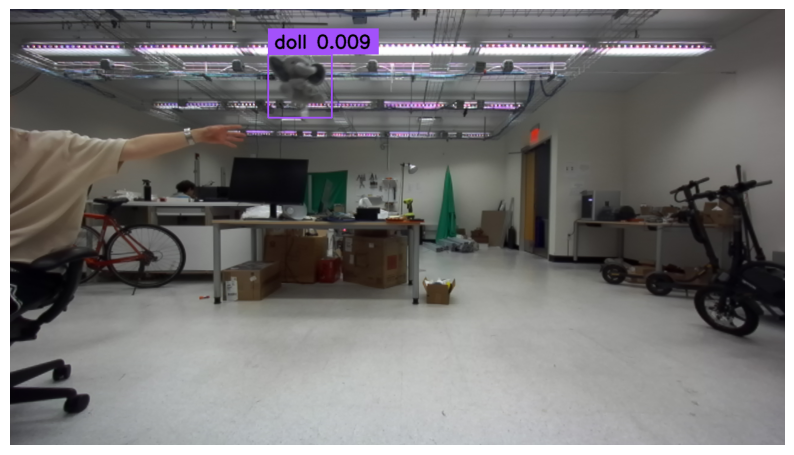

In [30]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

In [14]:
left_dir  = r'C:\Users\hzliu\OneDrive\Desktop\ZED-data-collector\SVO\exo_video_sequence\elephant_1\image_0'
right_dir = r'C:\Users\hzliu\OneDrive\Desktop\ZED-data-collector\SVO\exo_video_sequence\elephant_1\image_1'

In [15]:
import cv2
import glob
import os
import numpy as np
from kalman_filter import StereoCalib, KalmanFilter, triangulate, pick_banana_center

# Load stereo calibration
calib = StereoCalib.from_txt("calib_stereo.txt")
kf = KalmanFilter(dt=1/60)

# File paths
left_paths  = sorted(glob.glob(os.path.join(left_dir, "*.png")))
right_paths = sorted(glob.glob(os.path.join(right_dir, "*.png")))
assert len(left_paths) == len(right_paths), "Mismatched number of frames"
num_frames = len(left_paths)

pred_traj = []       # Filtered predictions (for plotting)
gt_traj = []         # Triangulated ground truth
pred_windows = []    # Predicted future trajectories

# Parameters
PRED_INTERVAL = 8   # Number of frames to predict
PRED_GAP = 8        # How often to start a new prediction
motion_threshold = 0.01  # Min displacement (m) to trigger initialization

# KF init buffer
init_buffer = []
kf_initialized = False

for frame_id in range(num_frames):
    img_L = cv2.imread(left_paths[frame_id])
    img_R = cv2.imread(right_paths[frame_id])

    preds_L = model.infer(img_L, confidence=0.003)
    preds_R = model.infer(img_R, confidence=0.003)
    det_L = pick_banana_center(preds_L)
    det_R = pick_banana_center(preds_R)
    
    if det_L and det_R:
        xyz = triangulate(det_L['u'], det_L['v'],
                          det_R['u'], det_R['v'], calib)
        gt_traj.append(xyz)

        if not kf_initialized:
            init_buffer.append(xyz)
            if len(init_buffer) == 2:
                kf.initialize(init_buffer[0], init_buffer[1])
                kf_initialized = True
                pred_traj.append(kf.x[0:3].ravel())
            else:
                pred_traj.append(xyz)
            continue

        kf.predict()
        kf.update(xyz)
        pred_traj.append(kf.x[:3].copy().ravel())

        # forecast (open-loop)
        if frame_id % PRED_GAP == 0 and frame_id + PRED_INTERVAL < num_frames:
            future_preds = []
            saved_kf_state = (kf.x.copy(), kf.P.copy())
            for _ in range(PRED_INTERVAL):
                kf.predict()
                future_preds.append(kf.x[:3].copy().ravel())
            pred_windows.append(future_preds)
            kf.x, kf.P = saved_kf_state

    else:
        # No detection: predict only
        if kf_initialized:
            kf.predict()
            pred_traj.append(kf.x[:3].copy().ravel())
        else:
            pred_traj.append(np.array([np.nan, np.nan, np.nan]))


In [16]:
print("GT trajectory frames:", len(gt_traj))
print("KF trajectory frames:", len(pred_traj))
print("Number of prediction windows:", len(pred_windows))

GT trajectory frames: 138
KF trajectory frames: 158
Number of prediction windows: 16


In [17]:
import numpy as np
import plotly.graph_objects as go

pred_traj = np.array(pred_traj)  # (N, 3)
gt_traj   = np.array(gt_traj)    # (N, 3)

print(pred_traj.shape)  # should be (N, 3)
print(gt_traj.shape)    # should be (N, 3)

fig = go.Figure()

min_len = min(len(gt_traj), len(pred_traj))
gt_traj = gt_traj[:min_len]
pred_traj = pred_traj[:min_len]

# 1. KF prediction (filtered, per frame)
fig.add_trace(go.Scatter3d(
    x=pred_traj[:, 0],
    y=pred_traj[:, 1],
    z=pred_traj[:, 2],
    mode='lines+markers',
    name='KF Filtered',
    line=dict(width=4, color='blue'),
    marker=dict(size=2)
))

# GT
fig.add_trace(go.Scatter3d(
    x=gt_traj[:, 0],
    y=gt_traj[:, 1],
    z=gt_traj[:, 2],
    mode='lines+markers',
    name='Ground Truth',
    line=dict(width=4, dash='dash', color='black'),
    marker=dict(size=2)
))

# 3. Multi-step predictions (20-step forecasts)
for i, seq in enumerate(pred_windows):
    pred_seq = np.array(seq)
    fig.add_trace(go.Scatter3d(
        x=pred_seq[:, 0],
        y=pred_seq[:, 1],
        z=pred_seq[:, 2],
        mode='lines+markers',
        name=f'Predicted Traj {i}',
        line=dict(width=2, color='red'),
        marker=dict(size=2)
    ))
fig.update_layout(
    scene=dict(
        xaxis_title='X (m)',
        yaxis_title='Y (m)',
        zaxis_title='Z (m)',
        aspectmode='data'
    ),
    legend=dict(x=0.05, y=0.95),
    title='Trajectory Prediction: Filtered vs 20-Step Forecasts'
)

fig.show()


(158, 3)
(138, 3)


## Using Non-Max Suppression (NMS) to Eliminate Double Detections

To eliminate duplicates, we will use [Non-Max Suppression (NMS)](https://blog.roboflow.com/how-to-code-non-maximum-suppression-nms-in-plain-numpy). NMS evaluates the extent to which detections overlap using the Intersection over Union metric and, upon exceeding a defined threshold, treats them as duplicates. Duplicates are then discarded, starting with those of the lowest confidence. The value should be within the range `[0, 1]`. The smaller the value, the more restrictive the NMS.







In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

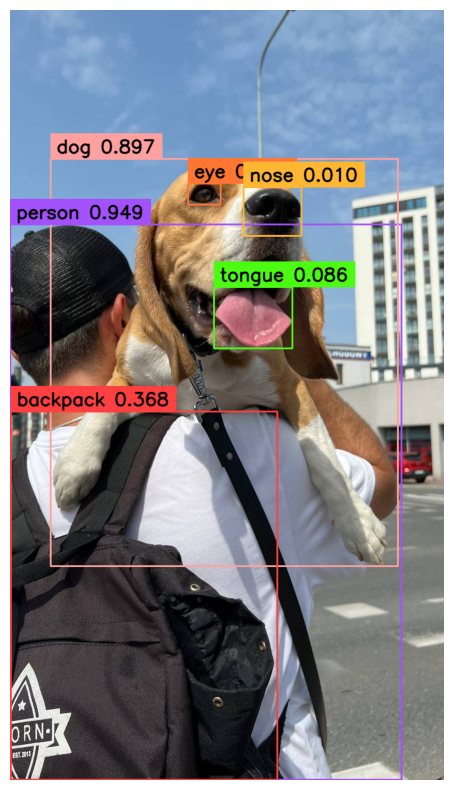

In [ ]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Video Processing

The [`get_video_frames_generator`](https://supervision.roboflow.com/latest/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.

In [1]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (10, 10))

NameError: name 'sv' is not defined

Let's update our list of classes. This time we are looking for `yellow filling`. The rest of the code performing detection, filtering and visualization remains unchanged.

## Final Result

Finally, we are ready to process our entire video. Now in truth we can appreciate the speed of YOLO-World.

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/yellow-filling-output.mp4"

In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

width, height = video_info.resolution_wh
frame_area = width * height
frame_area

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = model.infer(frame, confidence=0.002)
        detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
        detections = detections[(detections.area / frame_area) < 0.10]

        annotated_frame = frame.copy()
        annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(annotated_frame, detections)
        annotated_frame = LABEL_ANNOTATOR.annotate(annotated_frame, detections)
        sink.write_frame(annotated_frame)

100%|██████████| 442/442 [00:32<00:00, 13.51it/s]
